# Prediction stock returns with linear regression

## Imports & Settings

In [4]:
from pathlib import Path
from time import time
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import spearmanr, norm

from sklearn.metrics import mean_squared_error, make_scorer, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold

from empyrical import max_drawdown, sortino_ratio
from custom_scoring import spearman_corr

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings

In [5]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice

## Load Data

In [6]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

### Select Investment Universe

In [7]:
data = data[data.dollar_vol_rank<100]

In [8]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109663 entries, ('AAL', Timestamp('2013-07-24 00:00:00')) to ('ZTS', Timestamp('2014-12-09 00:00:00'))
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109663 non-null  float64
 1   dollar_vol             109663 non-null  float64
 2   dollar_vol_rank        109663 non-null  float64
 3   rsi                    109663 non-null  float64
 4   bb_high                109663 non-null  float64
 5   bb_low                 109663 non-null  float64
 6   atr                    109663 non-null  float64
 7   macd                   109663 non-null  float64
 8   return_1d              109663 non-null  float64
 9   return_5d              109663 non-null  float64
 10  return_10d             109663 non-null  float64
 11  return_21d             109663 non-null  float64
 12  return_42d             109663 non-null  float64
 13  return_63d    

### Create Model Data

In [9]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

## Linear Regression with sklearn

### Custom TimeSeriesCV

In [10]:
class TimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, train_period_length=12, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.train_period_length = train_period_length
        self.shuffle = shuffle
        self.test_end = n_splits * test_period_length

    @staticmethod
    def chunks(l, chunk_size):
        for i in range(0, len(l), chunk_size):
            yield l[i:i + chunk_size]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index.get_level_values('date')
                        .unique()
                        .sort_values(ascending=False))
        test_dates = unique_dates[:self.test_end]
        dates = X.reset_index()[['date']]
        for test_date in self.chunks(test_dates, self.test_period_length):
            test_end = min(test_date)
            idx = unique_dates.get_loc(test_end) + self.train_period_length + 1
            if len(unique_dates) <= idx:
                break

            train_start = unique_dates[idx]
            train_idx = dates[(dates.date < test_end) &
                              (dates.date > train_start)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

### Generate predictions with LinearRegression 

In [11]:
n_splits = 4 * 252
cv = TimeSeriesCV(n_splits=n_splits,
                  test_period_length=1,
                  train_period_length=252)
lr = LinearRegression()
target = 'target_5d'
test_results, result_idx, preds = [], [], []
ics = 0
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    if len(y_test) < 50:
        continue
    lr.fit(X=X_train, y=y_train)

    y_pred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
    ic, pval = spearmanr(y_pred, y_test)
    ics += ic
    if i % 100 == 0:
        print(f'{i:03} | {ics/i:>7.2%}')

    test_results.append([rmse, ic, pval])
    preds.append(y_test.to_frame('actuals').assign(predicted=y_pred))
    result_idx.append(y_test.index.get_level_values('date').min())

lr_result = pd.DataFrame(test_results, columns=[
    'rmse', 'ic', 'pval'], index=result_idx)
lr_result.dropna().to_hdf('data.h5', 'lr/metrics')
pd.concat(preds).to_hdf('data.h5', 'lr/predictions')

100 |   3.00%
200 |   1.05%
300 |   1.19%
400 |   1.16%
500 |   2.86%
600 |   2.91%
700 |   3.26%
800 |   3.96%


In [12]:
lr_result = pd.read_hdf('data.h5', 'lr/metrics')
lr_preds = pd.read_hdf('data.h5', 'lr/predictions')

In [13]:
lr_result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 867 entries, 2017-11-29 to 2014-06-23
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rmse    867 non-null    float64
 1   ic      867 non-null    float64
 2   pval    867 non-null    float64
dtypes: float64(3)
memory usage: 27.1 KB


In [14]:
def plot_ic_distribution(df, fname=None, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)    
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2%}\nMedian: {median:5.2%}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    plt.tight_layout()
    if fname is not None:
        plt.savefig(Path('figures', fname), dpi=300)    

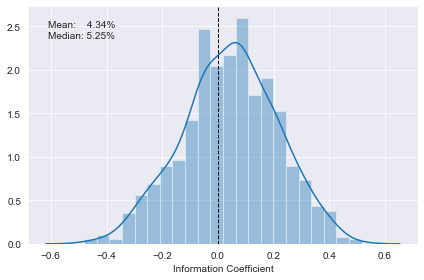

In [15]:
plot_ic_distribution(lr_result, fname='lr_ic_dist')

In [16]:
def plot_rolling_ic(df, fname):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.rolling(21).mean()
    rolling_result.ic.plot(ax=axes[0], title='Information Coefficient', lw=1)
    axes[0].axhline(0, lw=1, ls='--', color='k')

    rolling_result.rmse.plot(ax=axes[1], title='Root Mean Squared Error', lw=1, ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    plt.tight_layout()
    if fname is not None:
        plt.savefig(Path('figures', fname), dpi=300)

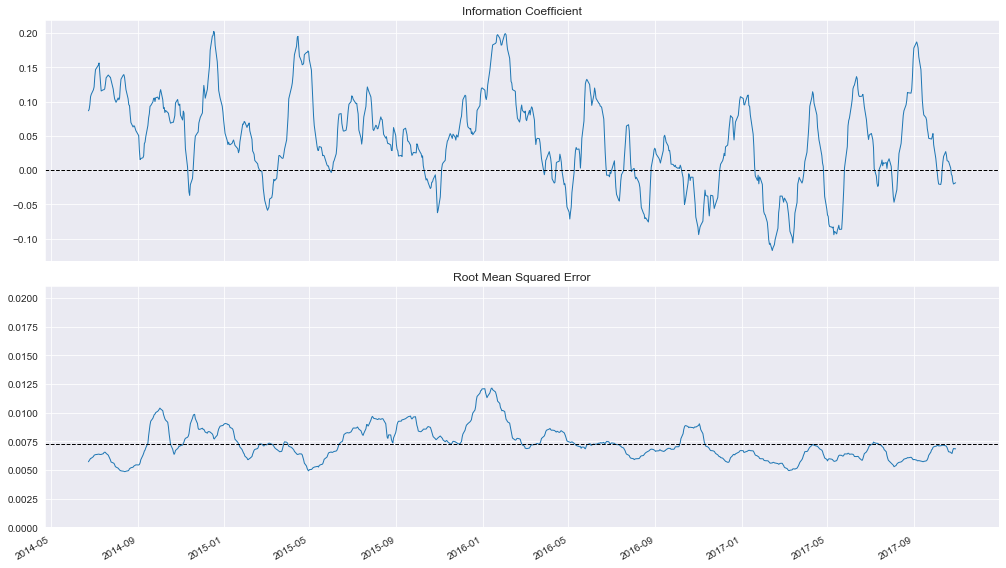

In [17]:
plot_rolling_ic(lr_result, fname='lr_ic_rolling')

In [21]:
def plot_preds_scatter(df, ticker=None, fname=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw':1, 'color':'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      stat_func=spearmanr,
                      kind='reg')
    j. ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j. ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j. ax_joint.set_xlabel('Predicted')
    j. ax_joint.set_ylabel('Actuals')
    if fname is not None:
        plt.savefig(Path('figures', fname), dpi=300)

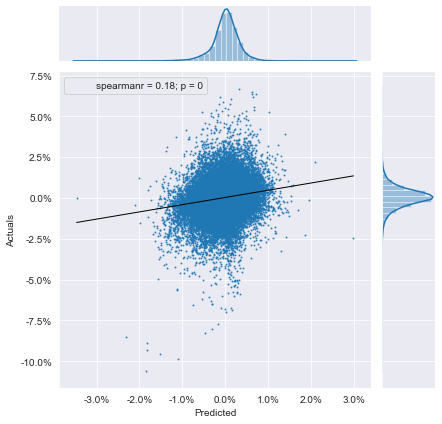

In [22]:
plot_preds_scatter(lr_preds, fname='lr_preds')

## Ridge Regression

In [23]:
n_splits = 252 * 4
alphas = np.logspace(-5, 5, 11)
alphas = sorted(list(alphas) + list(alphas * 5))
cv = TimeSeriesCV(n_splits=n_splits,
                  test_period_length=1,
                  train_period_length=252)
X = X.drop([c for c in X.columns if 'year' in c], axis=1)
target = 'target_5d'
ridge_coeffs, ridge_results, preds = {}, [], []
for alpha in alphas:
    print(alpha)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = rmses = 0
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        if len(y_test) < 40:
            continue

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
        ic, pval = spearmanr(y_pred, y_test)

        preds.append(y_test.to_frame('actuals').assign(
            predicted=y_pred, alpha=alpha))
        date = y_test.index.get_level_values('date').min()
        ridge_results.append([alpha, i, date, rmse, ic, pval])
        coeffs.append(pipe['model'].coef_)
        ics += ic
        rmses += rmse
        if i % 100 == 0:
            print(f'{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {rmses/i:>7.2%}')

    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

cols = ['alpha', 'split', 'date', 'rmse', 'ic', 'pval']
ridge_results = pd.DataFrame(ridge_results, columns=cols)
ridge_results.to_hdf('data.h5', 'ridge/metrics')
ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('data.h5', 'ridge/coeffs')
pd.concat(preds).to_hdf('data.h5', 'ridge/predictions')

1e-05
  4.6 | 100 |   3.02% |   0.67%
  9.1 | 200 |   0.97% |   0.63%
 13.7 | 300 |   0.99% |   0.66%
 18.2 | 400 |   1.09% |   0.67%
 22.7 | 500 |   2.87% |   0.71%
 27.2 | 600 |   2.92% |   0.74%
 31.7 | 700 |   3.27% |   0.73%
 36.0 | 800 |   3.95% |   0.74%
5e-05
  4.5 | 100 |   3.02% |   0.67%
  8.9 | 200 |   0.97% |   0.63%
 13.4 | 300 |   0.99% |   0.66%
 17.9 | 400 |   1.09% |   0.67%
 22.4 | 500 |   2.87% |   0.71%
 26.9 | 600 |   2.92% |   0.74%
 31.3 | 700 |   3.27% |   0.73%
 35.7 | 800 |   3.95% |   0.74%
0.0001
  4.5 | 100 |   3.02% |   0.67%
  9.0 | 200 |   0.97% |   0.63%
 13.5 | 300 |   0.99% |   0.66%
 18.0 | 400 |   1.09% |   0.67%
 22.5 | 500 |   2.87% |   0.71%
 26.9 | 600 |   2.92% |   0.74%
 31.3 | 700 |   3.27% |   0.73%
 35.7 | 800 |   3.95% |   0.74%
0.0005
  4.5 | 100 |   3.03% |   0.67%
  9.0 | 200 |   0.98% |   0.63%
 13.4 | 300 |   0.99% |   0.66%
 17.9 | 400 |   1.09% |   0.67%
 22.4 | 500 |   2.87% |   0.71%
 26.8 | 600 |   2.92% |   0.74%
 31.2 | 700 | 

### Evaluate Ridge Results

In [24]:
ridge_results = pd.read_hdf('data.h5', 'ridge/metrics')
ridge_coeffs = pd.read_hdf('data.h5', 'ridge/coeffs')
ridge_preds = pd.read_hdf('data.h5', 'ridge/predictions')

In [25]:
ridge_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19074 entries, 0 to 19073
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   alpha   19074 non-null  float64       
 1   split   19074 non-null  int64         
 2   date    19074 non-null  datetime64[ns]
 3   rmse    19074 non-null  float64       
 4   ic      19074 non-null  float64       
 5   pval    19074 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.0 MB


In [26]:
print(ridge_results.groupby('alpha').ic.describe())

              count      mean       std       min       25%       50%       75%       max
alpha                                                                                    
0.00001       867.0  0.043346  0.170467 -0.474805 -0.067184  0.048646  0.162194  0.522795
0.00005       867.0  0.043343  0.170470 -0.474805 -0.067091  0.048646  0.161830  0.523661
0.00010       867.0  0.043341  0.170479 -0.474805 -0.067091  0.048646  0.161830  0.523562
0.00050       867.0  0.043344  0.170492 -0.474855 -0.066752  0.048646  0.162187  0.523562
0.00100       867.0  0.043383  0.170487 -0.474063 -0.066229  0.048282  0.162350  0.523327
0.00500       867.0  0.043415  0.170576 -0.477168 -0.066744  0.048646  0.163174  0.520779
0.01000       867.0  0.043458  0.170853 -0.479035 -0.066586  0.048646  0.162846  0.519419
0.05000       867.0  0.043563  0.171751 -0.484205 -0.066618  0.049425  0.162783  0.517279
0.10000       867.0  0.043448  0.172121 -0.483302 -0.066100  0.048299  0.162152  0.514917
0.50000   

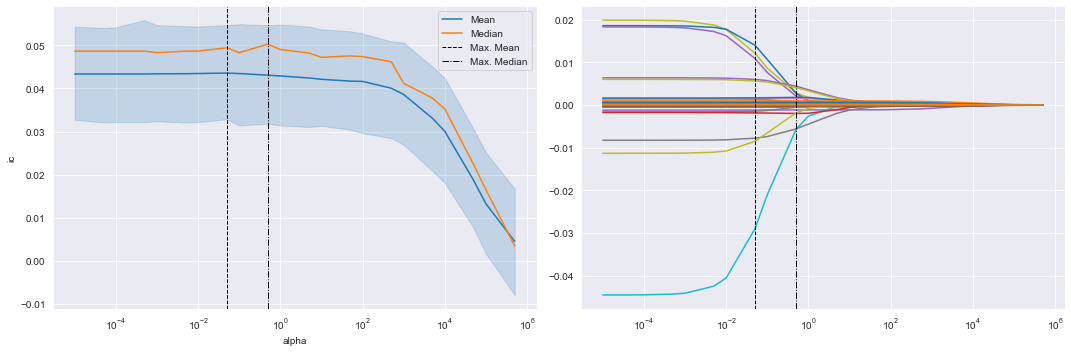

In [27]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

ax = sns.lineplot(x='alpha', y='ic', data=ridge_results,
                  estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = ridge_results.groupby('alpha').ic.agg(['mean', 'median'])
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')
axes[0].axvline(by_alpha['mean'].idxmax(), ls='--',
                c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.',
                c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1])
axes[1].axvline(by_alpha['mean'].idxmax(), ls='--',
                c='k', lw=1, label='Max. Mean')
axes[1].axvline(by_alpha['median'].idxmax(), ls='-.',
                c='k', lw=1, label='Max. Median')
fig.tight_layout()
fig.savefig('figures/ridge_path', dpi=300);

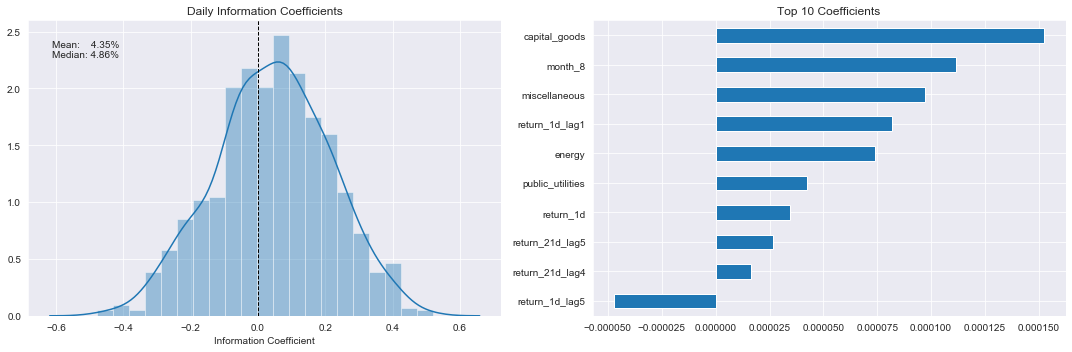

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_results[ridge_results.alpha==0.01], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[0.01].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[0.01, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')
fig.tight_layout()
fig.savefig('figures/ridge_top_coeffs', dpi=300);

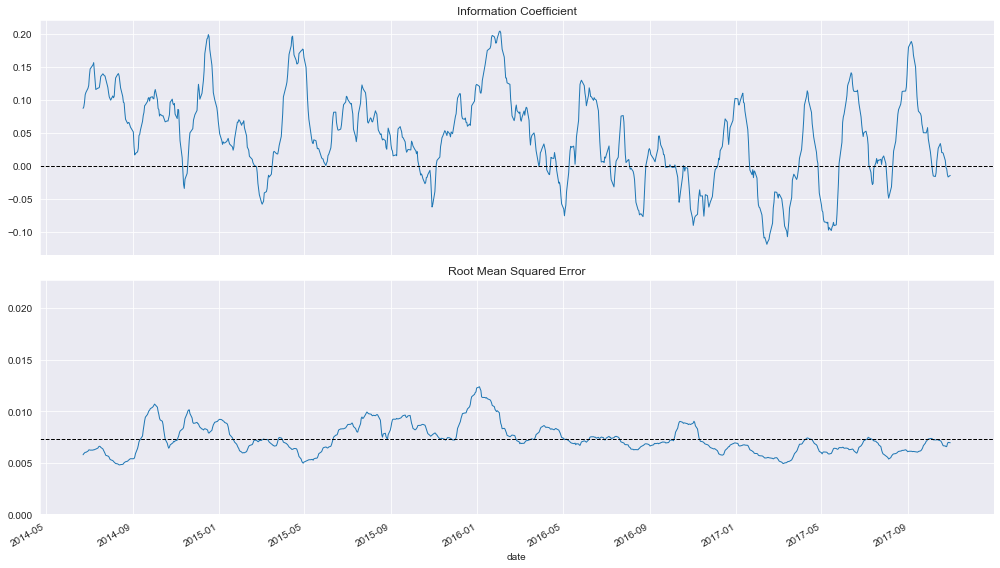

In [29]:
plot_rolling_ic(ridge_results[ridge_results.alpha==0.01].set_index('date'), fname='ridge_ic_rolling')

## Lasso CV

In [ ]:
target = 'target_5d'
n_splits = 4*252
alphas = np.logspace(-14, -4, 11)
cv = TimeSeriesCV(n_splits=n_splits,
                  test_period_length=1,
                  train_period_length=252)
scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)
target = 'target_5d'
lasso_coeffs, coeffs, lasso_results, preds = {}, [], [], []
for alpha in alphas:
    model = Lasso(alpha=alpha,
                  fit_intercept=False,
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = rmses = 0
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        if len(y_test) < 10:
            continue
        y_pred = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
        ic, pval = spearmanr(y_pred, y_test)

        preds.append(y_test.to_frame('actuals').assign(
            predicted=y_pred, alpha=alpha))
        date = y_test.index.get_level_values('date').min()
        lasso_results.append([alpha, i, date, rmse, ic, pval])
        coeffs.append(pipe['model'].coef_)
        ics += ic
        rmses += rmse
        if i % 100 == 0:
            print(f'{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {rmses/i:>7.2%}')

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

cols = ['alpha', 'split', 'date', 'rmse', 'ic', 'pval']
lasso_results = pd.DataFrame(lasso_results, columns=cols)
lasso_results.to_hdf('data.h5', 'lasso/metrics')
lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns)
lasso_coeffs.to_hdf('data.h5', 'lasso/coeffs')
pd.concat(preds).to_hdf('data.h5', 'lasso/predictions')

### Evaluate Lasso Results

In [ ]:
lasso_results.groupby('alpha').ic.agg(['mean', 'median'])

In [ ]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

ax = sns.lineplot(x='alpha', y='ic', data=lasso_results,
                  estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = lasso_results.groupby('alpha').ic.agg(['mean', 'median'])
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')
axes[0].axvline(by_alpha['mean'].idxmax(), ls='--',
                c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.',
                c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')

lasso_coeffs.T.plot(logx=True,
                  legend=False,
                  ax=axes[1])
axes[1].axvline(by_alpha['mean'].idxmax(), ls='--',
                c='k', lw=1, label='Max. Mean')
axes[1].axvline(by_alpha['median'].idxmax(), ls='-.',
                c='k', lw=1, label='Max. Median')
fig.tight_layout()
fig.savefig('figures/lasso_path', dpi=300);

In [ ]:
alpha = 1e-7
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_results[lasso_results.alpha==alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = lasso_coeffs.T.loc[alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.T.loc[alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')
fig.tight_layout()
fig.savefig('figures/lasso_top_coeffs', dpi=300);